In [1]:
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import cv2 as cv
import math, os

In [2]:
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
              landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
            ])

            mp_drawing.draw_landmarks(
                annotated_image,
                hand_landmarks_proto,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

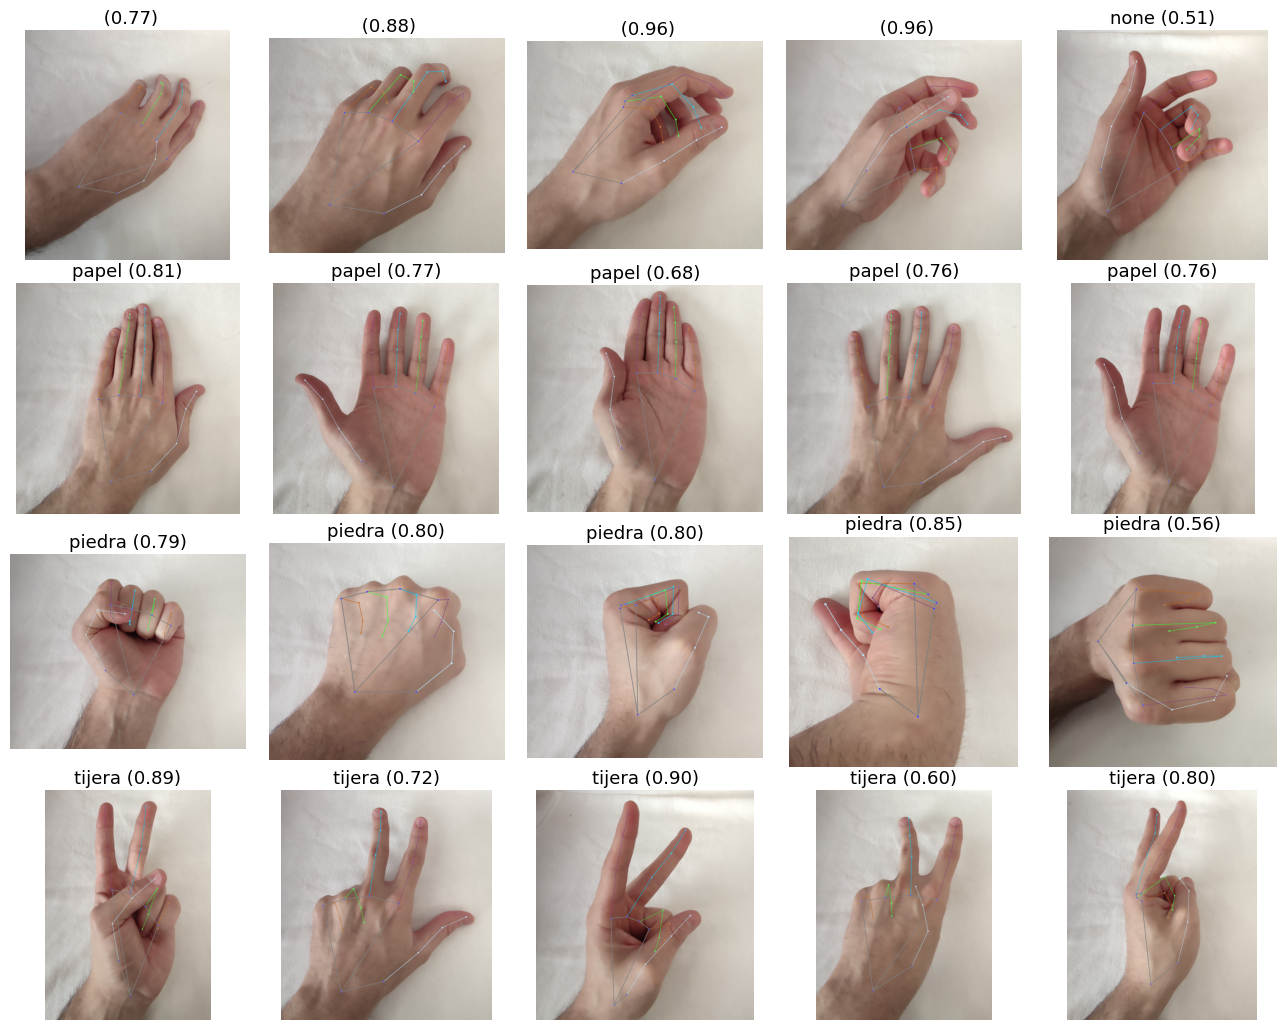

In [3]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
# base_options = python.BaseOptions(model_asset_path='model/exported_model/gesture_recognizer.task')
# base_options = python.BaseOptions(model_asset_path='model/exported_model_no_flip/gesture_recognizer.task')
# options = vision.GestureRecognizerOptions(base_options=base_options)
# recognizer = vision.GestureRecognizer.create_from_options(options)

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the image mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='model/exported_model_no_flip/gesture_recognizer.task'),
    # base_options=BaseOptions(model_asset_path='model/exported_model/gesture_recognizer.task'),
    running_mode=VisionRunningMode.IMAGE)

with GestureRecognizer.create_from_options(options) as recognizer:
    images = []
    results = []
    for image_file_name in os.listdir("test/"): # Put here your file with test images
        # STEP 3: Load the input image.
        image = mp.Image.create_from_file(f"test/{image_file_name}")

        # STEP 4: Recognize gestures in the input image.
        recognition_result = recognizer.recognize(image)

        # STEP 5: Process the result. In this case, visualize it.
        images.append(image)
        top_gesture = recognition_result.gestures[0][0]
        hand_landmarks = recognition_result.hand_landmarks
        results.append((top_gesture, hand_landmarks))

    display_batch_of_images_with_gestures_and_hand_landmarks(images, results)